# `Fitty`: Fitting growth curves

**Author: Raibatak Das**  
Last updated - **2024-SEP-24**

This jupyter notebook is part of the documentation for the Julia package `Fitty` for nonlinear least squares regression. This example shows how to use `Fitty` to infer the parameters for an asymptotic growth model from observed growth curves of tree height over time.

In [ ]:
using CSV, DataFrames, LaTeXStrings, PythonPlot, RDatasets, Statistics
using Pkg
Pkg.activate("..")
import Fitty

In [2]:
# # ONLY RELEVANT ON A MAC WITH RETINA DISPLAY

# # Run macro to produce high resolution plots
# # on a retina display
# @pyplot_retina
# # Update matplotlib settings
# mpl = PythonPlot.matplotlib
# mpl.rcParams["font.size"] = 14;
# mpl.rcParams["figure.dpi"] = 180;
# mpl.rcParams["axes.axisbelow"] = true;
# mpl.rcParams["axes.prop_cycle"] = mpl.cycler(color = mpl.colormaps["Dark2"].colors);

## 1. Load and plot data

This example used the `Loblolly` dataset that reports tree heights (in ft) of Loblolly pine trees over time (in yr) for seeds from different sources (Ref: https://stat.ethz.ch/R-manual/R-patched/library/datasets/html/Loblolly.html).

In [3]:
data = dataset("datasets", "Loblolly")

Row,x,Height,Age,Seed
,String,Float64,Int32,Cat…
1,1,4.51,3,301
2,15,10.89,5,301
3,29,28.72,10,301
4,43,41.74,15,301
5,57,52.7,20,301
6,71,60.92,25,301
7,2,4.55,3,303
8,16,10.92,5,303
9,30,29.07,10,303


Plot data

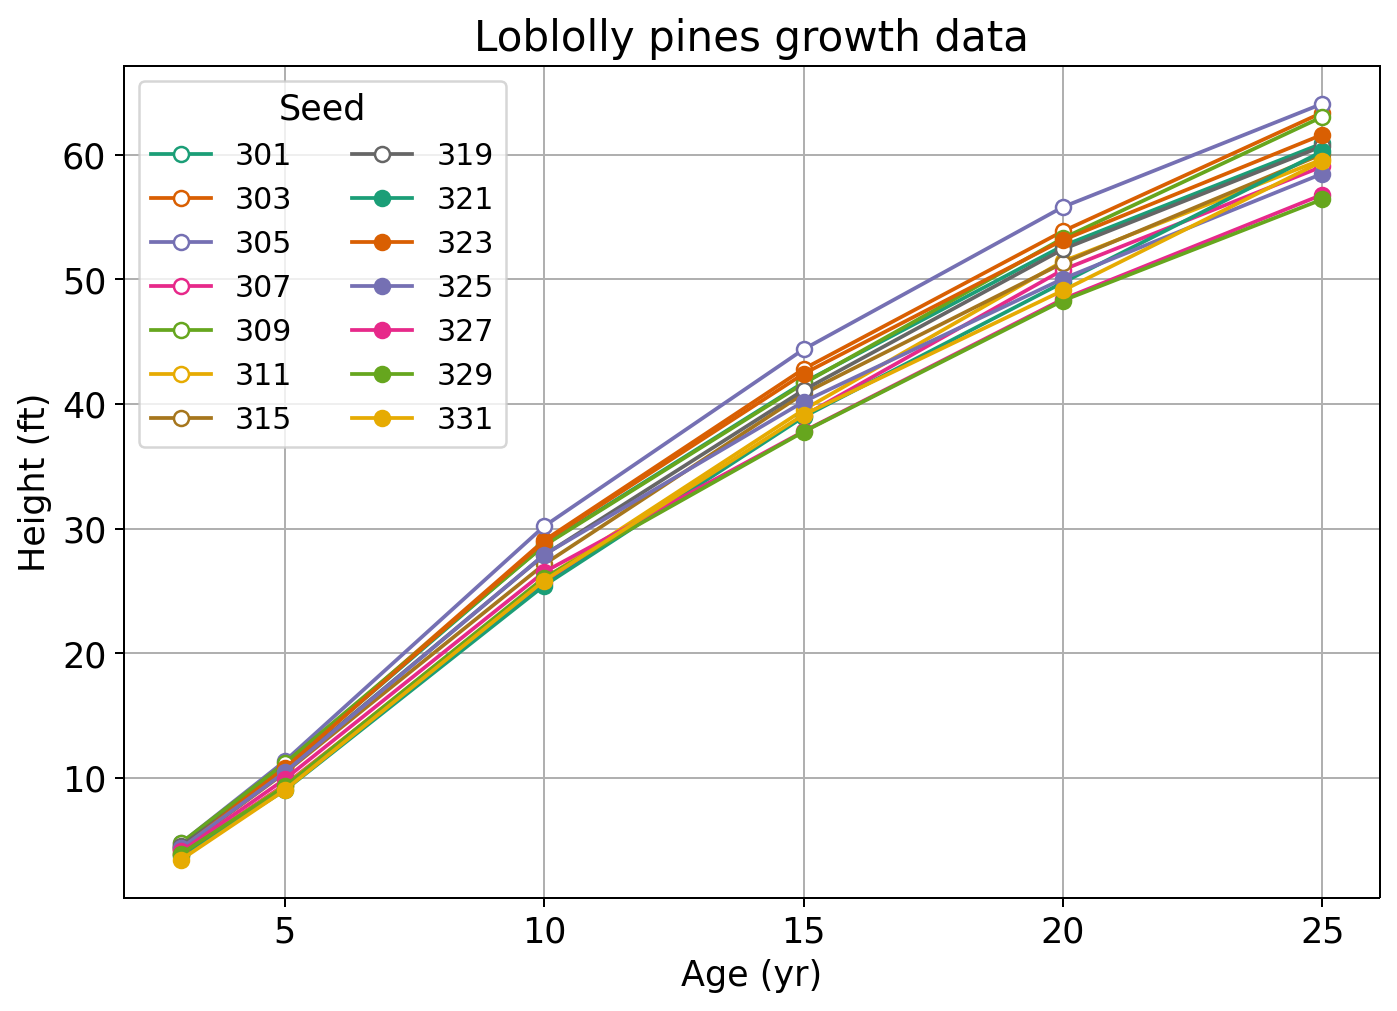

In [4]:
fig, ax = subplots(figsize = (9, 6))
for (s, df) in pairs(groupby(data, :Seed, sort = false))
    seed = s.Seed
    if seed in ["301", "303", "305", "307", "309", "311", "315", "319"]
        ax.plot(df.Age, df.Height, "o-", mfc = "w", label = "$seed")
    else
        ax.plot(df.Age, df.Height, "o-", label = "$seed")
    end
end
ax.set_xlabel("Age (yr)")
ax.set_ylabel("Height (ft)")
ax.legend(title = "Seed", ncol = 2, fontsize = 12)
ax.set_title("Loblolly pines growth data")
ax.grid();

## 2. Define model and residual functions

These growth profiles are fit to an asymptotic growth curve which models the height $h(t)$ as:
$$ h(t) = h_0 + (h_\text{\sf max} - h_0) \cdot \left( 1 - e^{-k t} \right) $$

The following code block defines the model and a residual function for this dataset.

In [5]:
# Asymptotic growth model
h(θ, t) = @. θ.hmax + (θ.h0 - θ.hmax) * exp(-θ.k*t)

# Residual function for `Loblolly` dataset
residual(θ, df) = df.Height - h(θ, df.Age)

residual (generic function with 1 method)

## 3. Global fit to all data

This approach assumes that all the observed growth curves arise from the same underlying parameterization and fits the curves simultaneously. 

### Unconstrained fit

First fit the data with no parameter bounds

In [6]:
guess = (h0 = 0, hmax = 100, k = 0.1)
fit = Fitty.nlsfit(residual, guess, data = data, bootstrap = true);

Fit converged in 23 steps from intial guess [0.0, 100.0, 0.1]
to final estimate [-8.533, 102.262, 0.039]
2000 bootstrap fits converged out of 2007 tries
Fit results: 

Table with 5 columns and 3 rows:
     Parameter  Bounds       Estimate   StdErr      CI
   ┌─────────────────────────────────────────────────────────────────────
 1 │ h0         [-Inf, Inf]  -8.53306   0.744121    [-9.07469, -8.02848]
 2 │ hmax       [-Inf, Inf]  102.262    5.42051     [97.1009, 108.022]
 3 │ k          [-Inf, Inf]  0.0389245  0.00317067  [0.0359425, 0.042078]

Sum of squared residuals = 2.373e+02
Degrees of freedom = 84 - 3 = 81
Residual standard error = 1.712e+00
95.0% Bayesian credible intervals computed using 2000 bootstrap replicates


Plot global fit

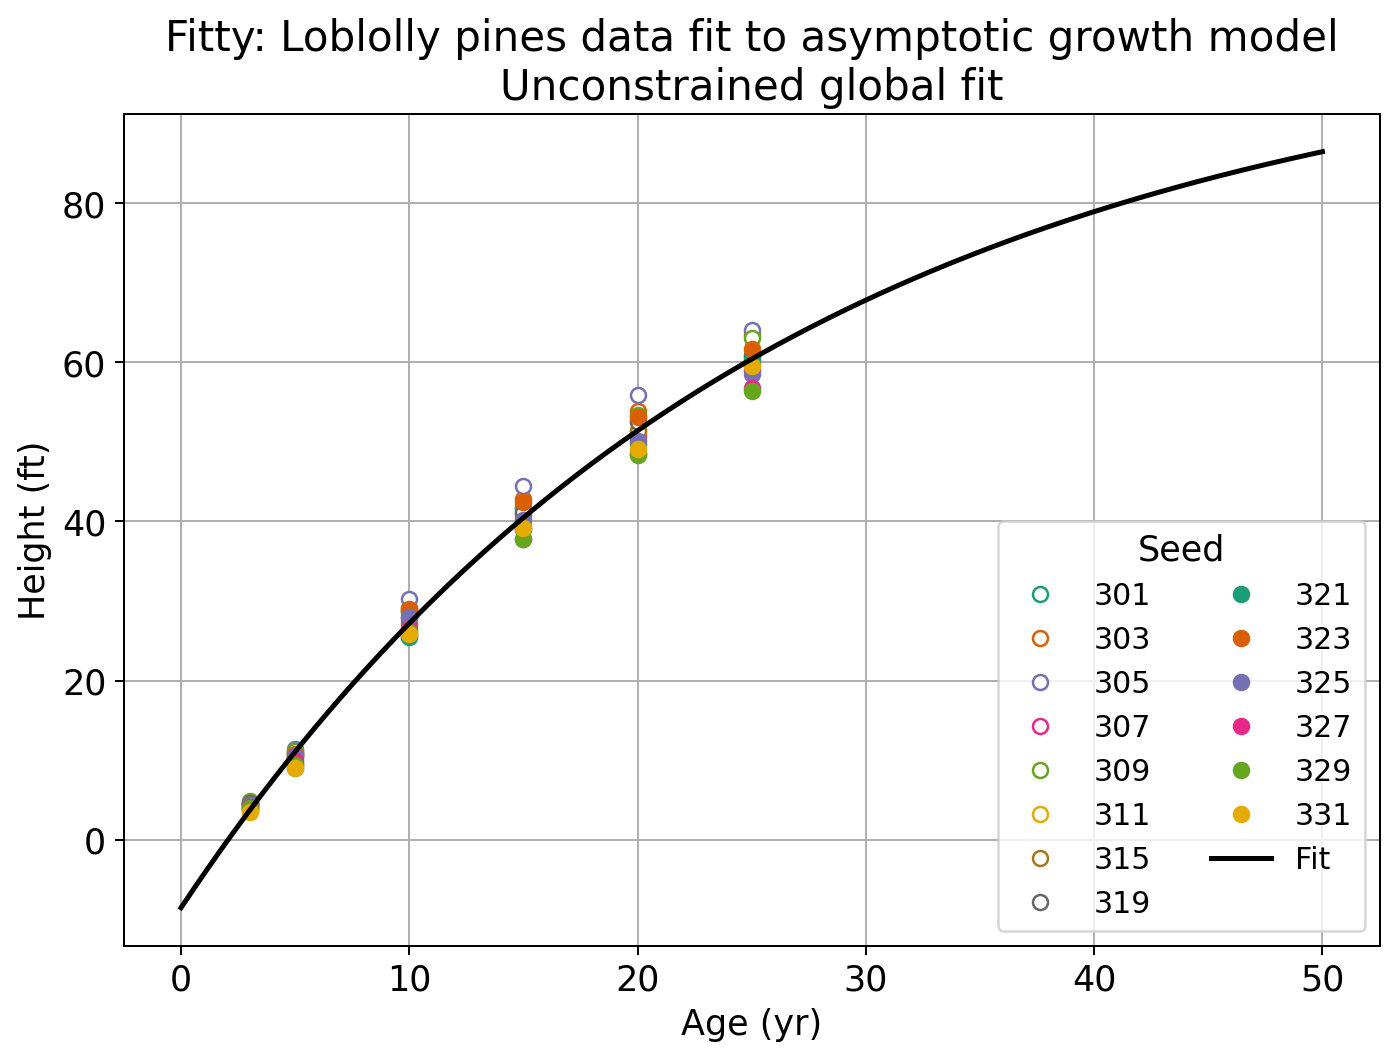

In [7]:
yrs = range(0, 50, step = 1/12)
pred = h(fit.fit, yrs)

fig, ax = subplots(figsize = (9, 6))
for (s, df) in pairs(groupby(data, :Seed, sort = false))
    # Plot data
    seed = s.Seed
    if seed in ["301", "303", "305", "307", "309", "311", "315", "319"]
        ax.plot(df.Age, df.Height, "o", mfc = "w", label = "$seed")
    else
        ax.plot(df.Age, df.Height, "o", label = "$seed")
    end
    # Plot fit
end
ax.plot(yrs, pred, "k-", lw = 2, label = "Fit")
ax.set_xlabel("Age (yr)")
ax.set_ylabel("Height (ft)")
ax.legend(title = "Seed", ncol = 2, fontsize = 12)
ax.set_title("Fitty: Loblolly pines data fit to asymptotic growth model\nUnconstrained global fit")
ax.grid();

### Constrained fit

For the unconstrained fit above, the estimated value of the initial height, $h_0$, is negative, which is unphysical. The following constrained fit forces the initial height to be 0. Note that the `lb` and `ub` values are both set to 0 for this parameter. Also add an upper bound on `k` to ensure convergence.

In [8]:
guess = (h0 = 0, hmax = 100, k = 0.1)
altfit = Fitty.nlsfit(residual, guess, 
                   data = data,
                   lb = [0, 0, 0], 
                   ub = [0, Inf, 0.1], 
                   bootstrap = true);

Fit converged in 34 steps from intial guess [0.0, 100.0, 0.1]
to final estimate [0.0, 344.346, 0.008]
2000 bootstrap fits converged out of 2003 tries
Fit results: 

Table with 5 columns and 3 rows:
     Parameter  Bounds      Estimate    StdErr      CI
   ┌───────────────────────────────────────────────────────────────────────
 1 │ h0         [0.0, 0.0]  0.0         0.0         [0.0, 0.0]
 2 │ hmax       [0.0, Inf]  344.346     128.349     [265.096, 507.426]
 3 │ k          [0.0, 0.1]  0.00790978  0.00319443  [0.00522391, 0.0105179]

Sum of squared residuals = 6.931e+02
Degrees of freedom = 84 - 2 = 82
Residual standard error = 2.907e+00
95.0% Bayesian credible intervals computed using 2000 bootstrap replicates


Plot constrained and unconstrained fits

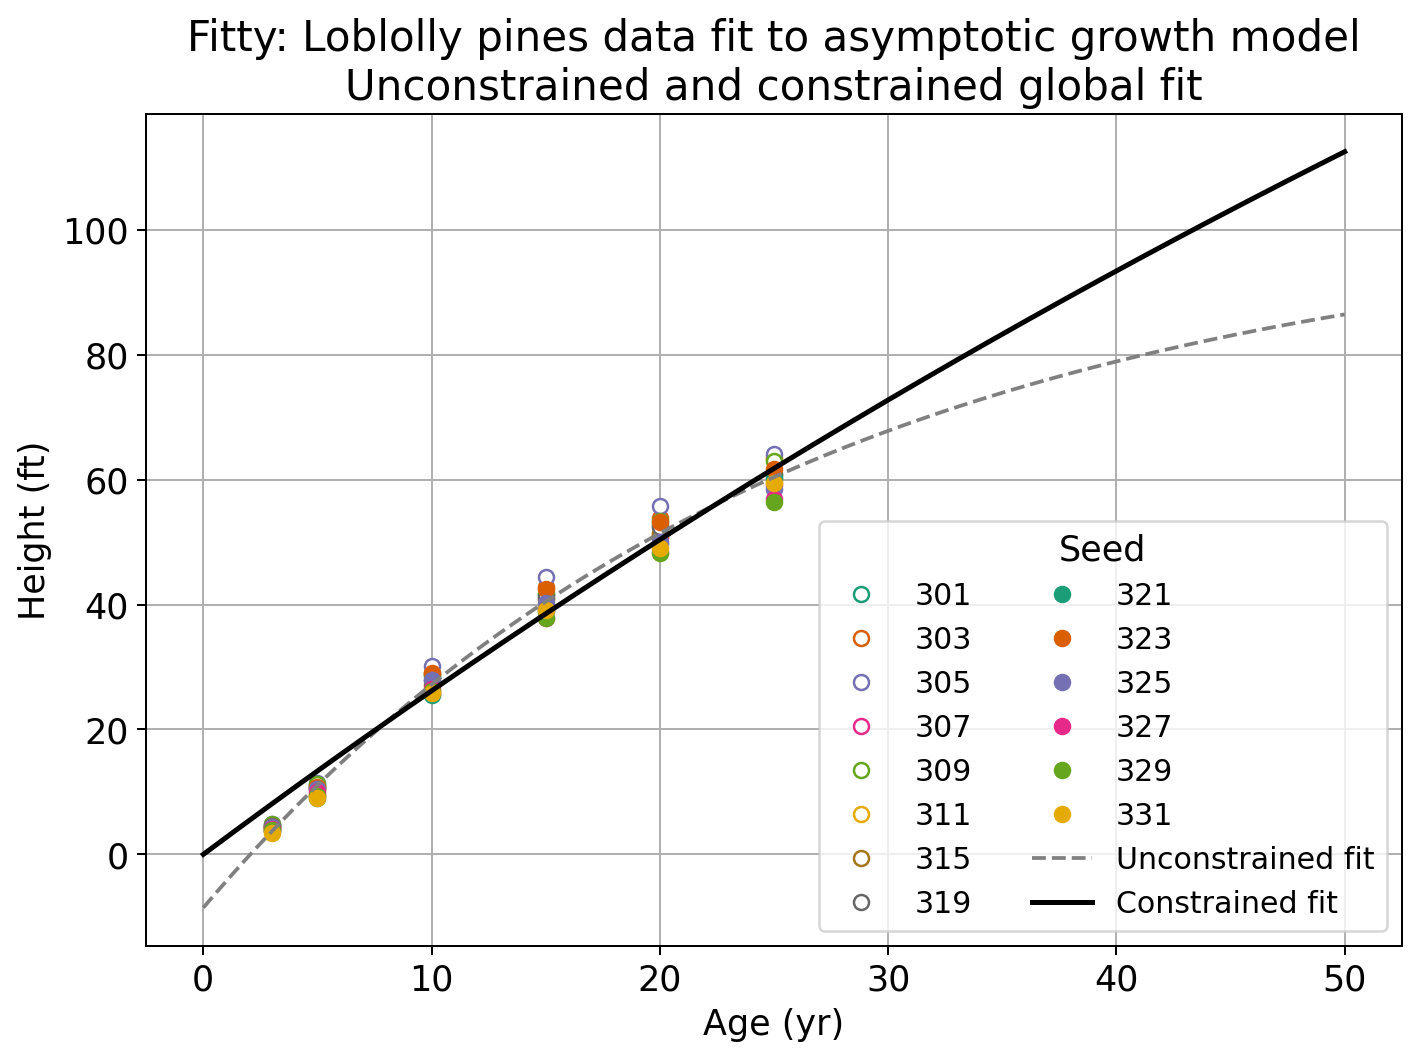

In [9]:
altpred = h(altfit.fit, yrs)

fig, ax = subplots(figsize = (9, 6))
for (s, df) in pairs(groupby(data, :Seed, sort = false))
    # Plot data
    seed = s.Seed
    if seed in ["301", "303", "305", "307", "309", "311", "315", "319"]
        ax.plot(df.Age, df.Height, "o", mfc = "w", label = "$seed")
    else
        ax.plot(df.Age, df.Height, "o", label = "$seed")
    end
    # Plot fit
end
ax.plot(yrs, pred, "--", color = "gray", lw = 1.5, label = "Unconstrained fit")
ax.plot(yrs, altpred, "k-", lw = 2, label = "Constrained fit")

ax.set_xlabel("Age (yr)")
ax.set_ylabel("Height (ft)")
ax.legend(title = "Seed", ncol = 2, fontsize = 12)
ax.set_title("Fitty: Loblolly pines data fit to asymptotic growth model\nUnconstrained and constrained global fit")
ax.grid();

### Comments

The unconstrained fit shows an overall better match to the observed data but the trade off is that the estimated value of the initial height is negative. This suggests that the asymptotic growth model with $h_0 = 0$ is unsuitable to describe the early stage of growth between 0 and 3 years. To predict tree height in the future, for example, say at 40 years, the unconstrained fit is likely to be more accurate. 

## 4. Individual fits

Split the dataset by `Seed` and fit each growth curve separately with an unconstrained fit

In [10]:
indifits = Dict()
guess = (h0 = 0, hmax = 100, k = 0.01)
for (s, df) in pairs(groupby(data, :Seed, sort = false))
    seed = s.Seed
    print("Fitting seed $seed\n")
    indifits[seed] = Fitty.nlsfit(residual, guess, data = df, bootstrap = false, quiet = true)
end

Fitting seed 301
Fitting seed 303
Fitting seed 305
Fitting seed 307
Fitting seed 309
Fitting seed 311
Fitting seed 315
Fitting seed 319
Fitting seed 321
Fitting seed 323
Fitting seed 325
Fitting seed 327
Fitting seed 329
Fitting seed 331


### Plot indivdual fits

Plot individual fits

In [11]:
# Generate individual predictions
t = range(3, 30, step = 1/12)
preds = Dict()
for s in unique(data.Seed)
    θ = indifits[s].fit
    preds[s] = h(θ, t)
end

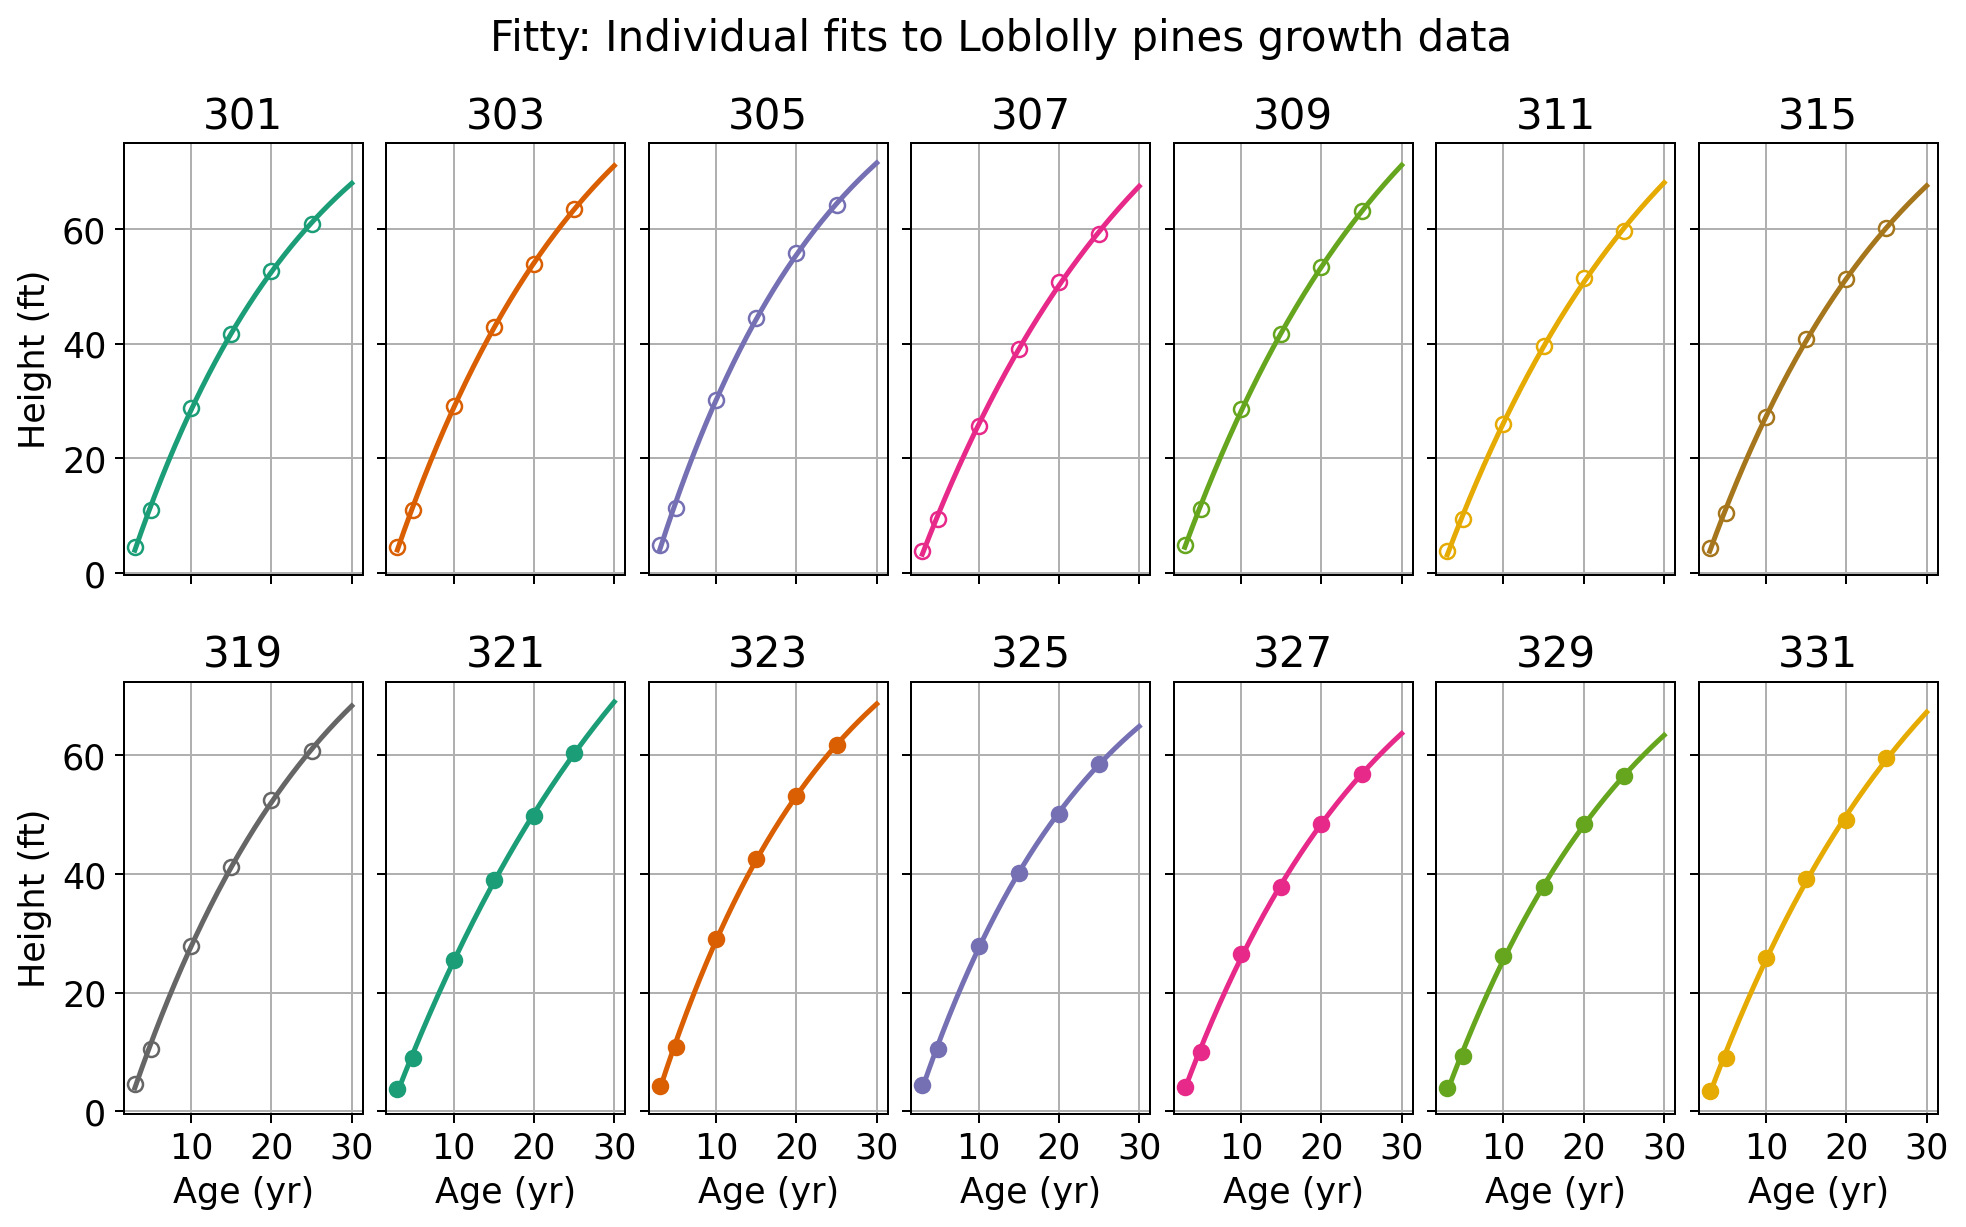

In [12]:
fig, splots = subplots(figsize = (13, 7), ncols = 7, nrows = 2, 
                       sharex = "all", sharey = "row")

spl = splots.ravel()
for (jj, (s, df)) in enumerate(pairs(groupby(data, :Seed, sort = false)))
    ax = spl[jj-1]
    seed = s.Seed
    color = "C$(jj-1)"
    # Plot data
    if seed in ["301", "303", "305", "307", "309", "311", "315", "319"]
        ax.plot(df.Age, df.Height, "o", color = color, mfc = "w")
    else
        ax.plot(df.Age, df.Height, "o", color = color)
    end
    # Overlay fit
    ax.plot(t, preds[seed], color = color, lw = 2)
    if jj in [1, 8]
        ax.set_ylabel("Height (ft)")
    end
    if jj > 7
        ax.set_xlabel("Age (yr)")
    end
    ax.set_title(seed)
    ax.grid()
end
suptitle("Fitty: Individual fits to Loblolly pines growth data")
subplots_adjust(hspace = 0.25, wspace = 0.1);

## 5. Compare parameter estimates 

Plot estimated values of the three model parameters for the global -vs- individual fits

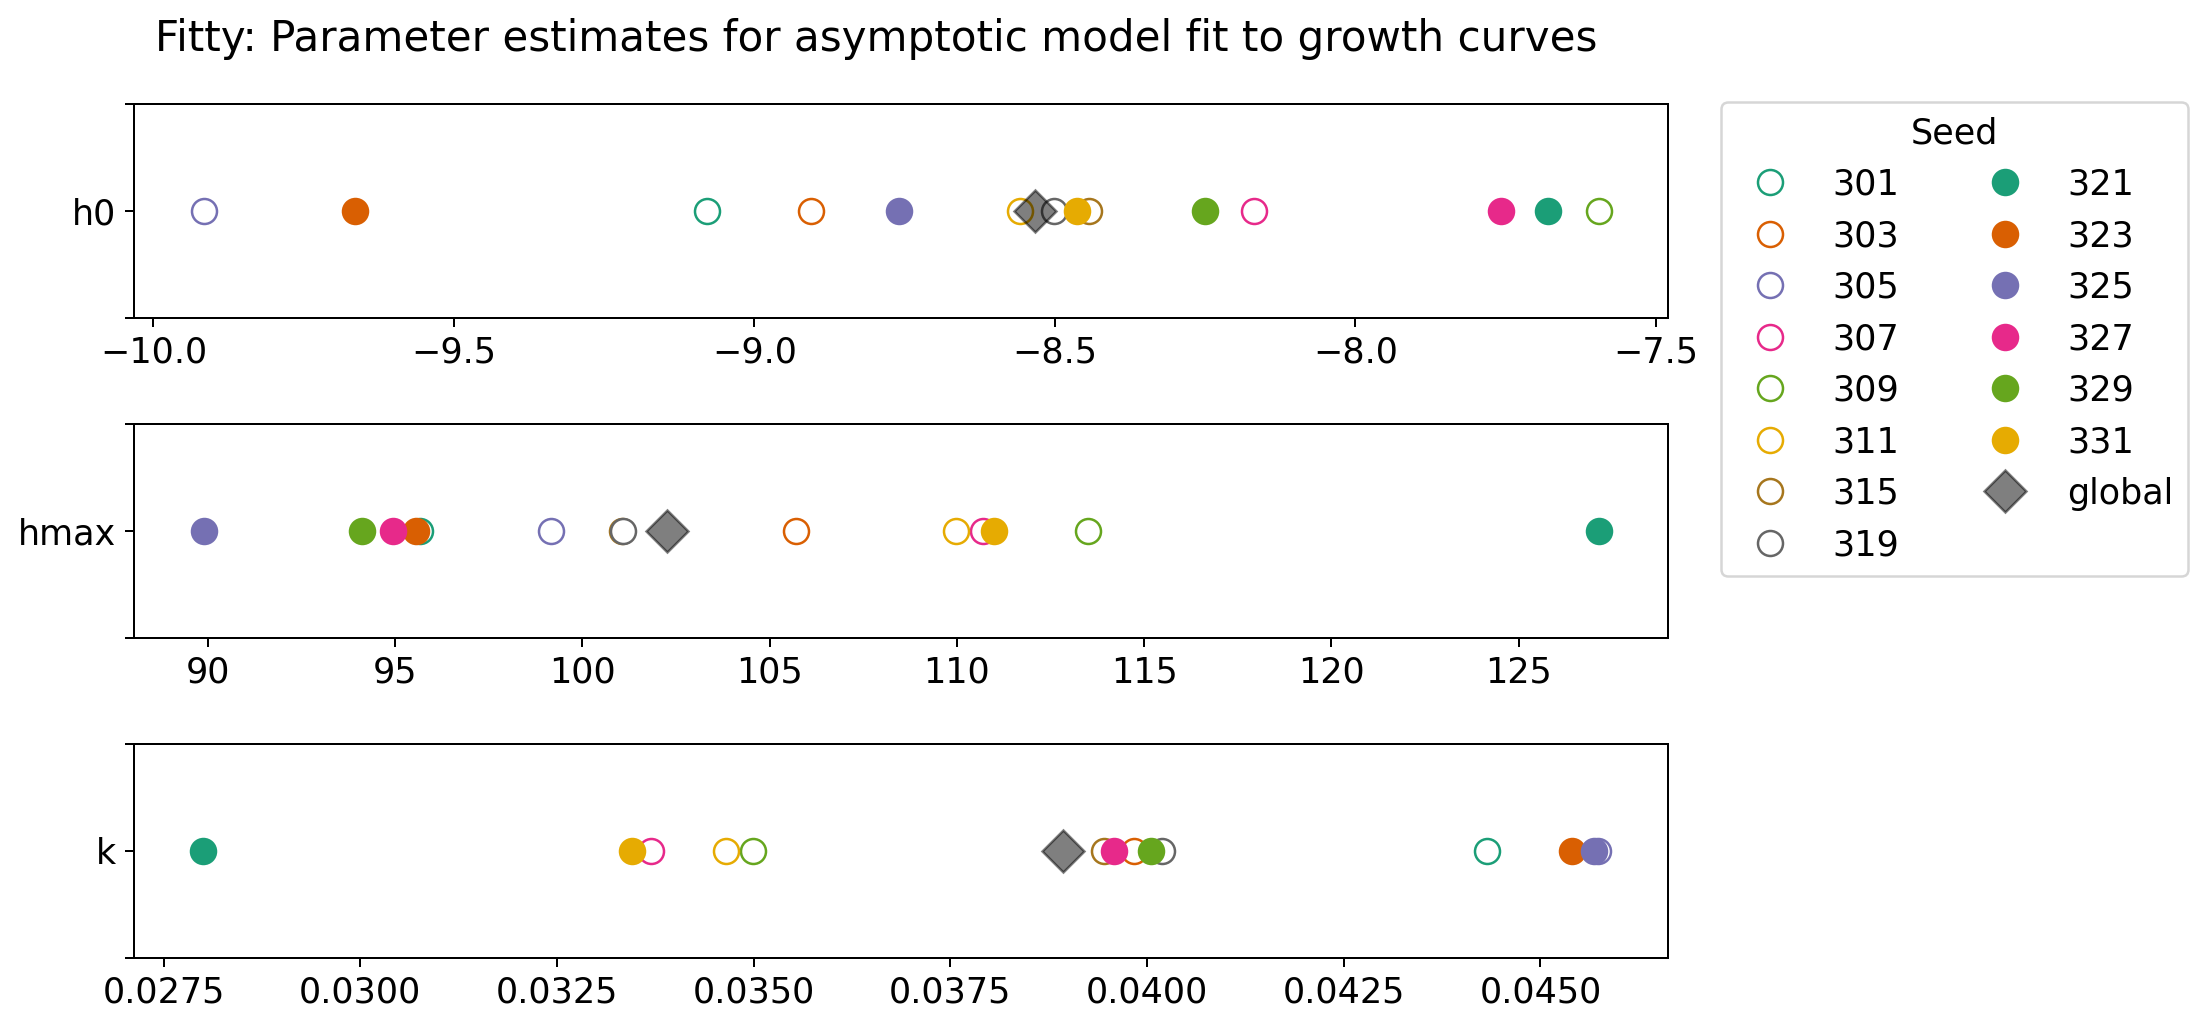

In [13]:
fig, splots = subplots(figsize = (11, 6), nrows = 3)

seeds = ["301", "303", "305", "307", "309", "311", "315", "319",
         "321", "323", "325", "327", "329", "331"]
for (jj, par) in enumerate((:h0, :hmax, :k))
    ax = splots[jj-1]
    for (k, s) in enumerate(seeds)
        color = "C$(k-1)"
        p = indifits[s].fit[par]
        if s in seeds[1:8]
            ax.plot(p, 0, "o", ms = 10, mfc = "w", label = "$s")
        else 
            ax.plot(p, 0, "o", ms = 10, label = "$s")
        end
    end
    p = fit.fit[par]
    ax.plot(p, 0, "kD", ms = 12, alpha = 0.5, label = "global")
    ax.set_yticks([-1, 0, 1])
    ax.set_yticklabels(["", par, ""])
end

ax = splots[1]
ax.legend(title = "Seed", ncols = 2, loc = "right", bbox_to_anchor = [1.35, 1.4])
suptitle("Fitty: Parameter estimates for asymptotic model fit to growth curves")
subplots_adjust(top = 0.9, hspace = 0.5);